# Data Exploration & Preprocessing

1. Load the Twitter sentiment analysis dataset
2. Perform exploratory data analysis to understand distribution of sentiments and entities
3. Implement text preprocessing functions to clean and standardize the tweets
5. Analyze the most common tokens for each sentiment class
6. Handle imbalance dataset
7. Saved the cleaned dataset for further feature engineering

## Setup and Imports

In [ ]:
!pip install emoji

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# NLP processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Emoji handling
import emoji

# Visualization settings
plt.style.use('ggplot')
sns.set(style='whitegrid')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
training_set_path = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/data/twitter_training.csv'
validation_set_path = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/data/twitter_validation.csv'

# Load dataset and combine
try:
    train_df = pd.read_csv(training_set_path)
    print(f"Training set loaded with shape: {train_df.shape}")
    val_df = pd.read_csv(training_set_path)
    print(f"Validation set loaded with shape: {val_df.shape}")

    df = pd.concat([train_df, val_df], ignore_index=True)
    print(f"Combine set loaded with shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please update the dataset path or upload the dataset file.")

Mounted at /content/drive
Training set loaded with shape: (74681, 4)
Validation set loaded with shape: (74681, 4)
Combine set loaded with shape: (149362, 4)


## Exploratory Data Analysis (EDA)

In [ ]:
header = ['id', 'entity', 'sentiment', 'content']
df.columns = header

# Display basic info about the dataset
print("\nDataset Info:")
df.info()

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149362 entries, 0 to 149361
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         149362 non-null  int64 
 1   entity     149362 non-null  object
 2   sentiment  149362 non-null  object
 3   content    147990 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.6+ MB

First 5 rows of the dataset:


,id,entity,sentiment,content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
# Check for missing values
print("\nMissing values in each column:")
df.isnull().sum()


Missing values in each column:


,0
id,0
entity,0
sentiment,0
content,1372


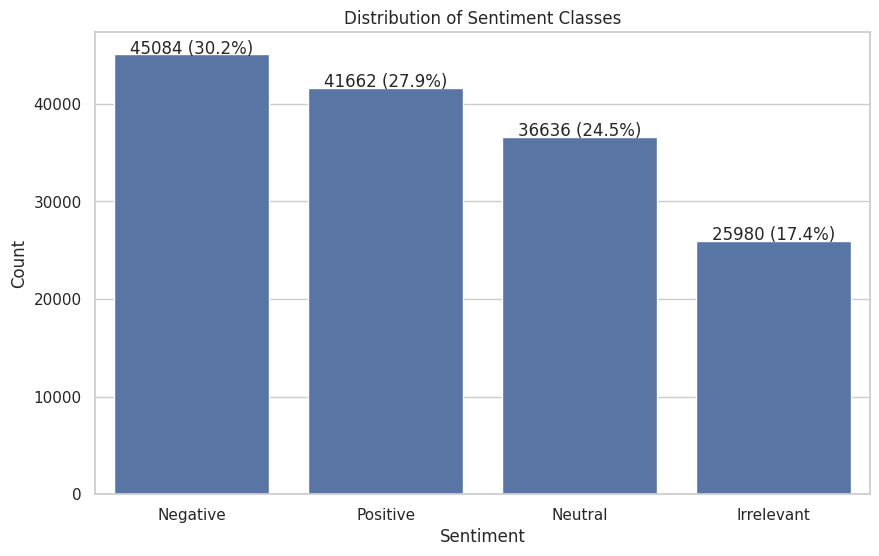

In [ ]:
# Distribution of sentiment classes
plt.figure(figsize=(10, 6))
sentiment_counts = df['sentiment'].value_counts()
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add value labels on top of bars
for i, count in enumerate(sentiment_counts.values):
    ax.text(i, count + 50, f"{count} ({count/sentiment_counts.sum()*100:.1f}%)", ha='center')

plt.show()

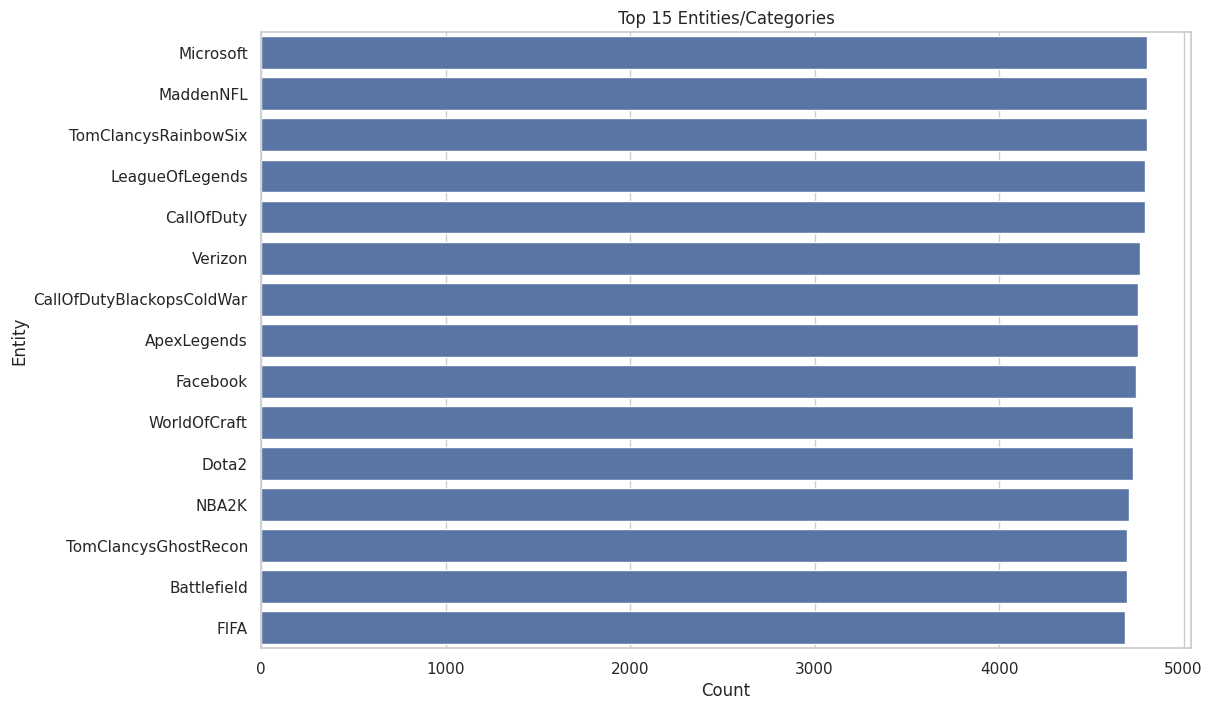

In [ ]:
# Distribution of entities/categories
plt.figure(figsize=(12, 8))
entity_counts = df['entity'].value_counts().head(15)  # Top 15 entities
sns.barplot(x=entity_counts.values, y=entity_counts.index)
plt.title('Top 15 Entities/Categories')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.show()

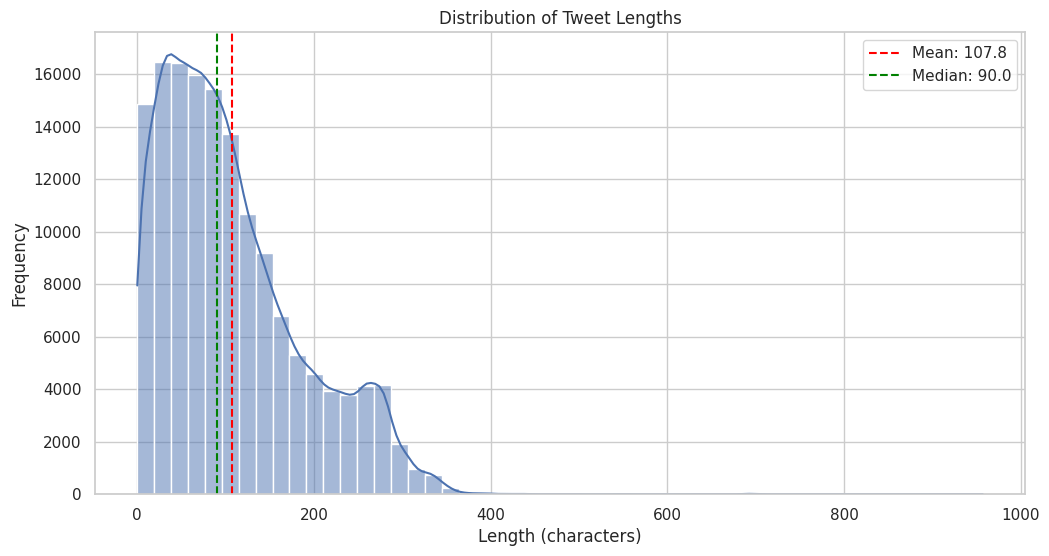

Tweets with 0 or 1 words: 2050 (1.37% of the dataset)


In [ ]:
# Analyze tweet length distribution
df['tweet_length'] = df['content'].apply(lambda x: len(x) if isinstance(x, str) else 0)

plt.figure(figsize=(12, 6))
sns.histplot(df['tweet_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.axvline(x=df['tweet_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["tweet_length"].mean():.1f}')
plt.axvline(x=df['tweet_length'].median(), color='green', linestyle='--', label=f'Median: {df["tweet_length"].median():.1f}')
plt.legend()
plt.show()

very_short_tweets = len(df[df['tweet_length'] <= 1])
total_tweets = len(df)
print(f"Tweets with 0 or 1 words: {very_short_tweets} ({very_short_tweets/total_tweets:.2%} of the dataset)")


In [ ]:
# Sample tweets from each sentiment class
print("\nSample Positive Tweet:")
print(df[df['sentiment'] == 'Positive']['content'].sample(1).values[0])

print("\nSample Negative Tweet:")
print(df[df['sentiment'] == 'Negative']['content'].sample(1).values[0])

print("\nSample Neutral Tweet:")
print(df[df['sentiment'] == 'Neutral']['content'].sample(1).values[0])


Sample Positive Tweet:
I love how I've been playing csgo on 6 different accounts for 5 years (I hate VAC lol) pic.twitter.com / GJBvDDPTVm

Sample Negative Tweet:
Fucking adore this demon hunter

Sample Neutral Tweet:
@ wykrhm I know you're slower than @ Dota2, don't try to fool us...


## Preprocessing Functions
- comparing to normal text, twitter posts has unique features of user mentions (@), emojis, and embedded HTML tags. We have to deal with these in order to provide a better understandings in model training phases.
- some tweets are extremely short (0 or 1 words). These provide very little meaningful information for sentiment analysis.



In [ ]:
def extract_emojis(text):
    """Extract emojis from text and return them as a list of textual representations"""
    emoji_list = []
    for char in text:
        if char in emoji.distinct_emoji_list(text):
            emoji_name = emoji.demojize(char).replace(':', ' ').strip()
            emoji_list.append(emoji_name)
    return emoji_list

def preprocess_tweet(text, remove_emoji=False):
    """Complete preprocessing pipeline"""
    if pd.isna(text):
        return ""

    # Optional: extract emoji text
    emojis = extract_emojis(text) if not remove_emoji else []

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Replace @mentions with [USER]
    text = re.sub(r'@[\w]+', '[USER]', text)

    # Remove RT (retweet indicator)
    text = re.sub(r'\brt\b', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Append emoji text if not removed
    if emojis and not remove_emoji:
        text += " " + " ".join(emojis)

    return text

## Apply Preprocessing to the Dataset

In [ ]:
# Test preprocessing on a few examples
sample_tweets = df['content'].head(3).tolist()

for i, tweet in enumerate(sample_tweets):
    print(f"\nOriginal Tweet {i+1}:\n{tweet}")

    processed_text = preprocess_tweet(tweet)

    print(f"\nProcessed Tweet {i+1}:\n{processed_text}")


Original Tweet 1:
I am coming to the borders and I will kill you all,

Processed Tweet 1:
i am coming to the borders and i will kill you all,

Original Tweet 2:
im getting on borderlands and i will kill you all,

Processed Tweet 2:
im getting on borderlands and i will kill you all,

Original Tweet 3:
im coming on borderlands and i will murder you all,

Processed Tweet 3:
im coming on borderlands and i will murder you all,


In [ ]:
# Apply preprocessing to the entire dataset
# This might take some time depending on the dataset size
print("Preprocessing tweets...")

# Create new columns for processed data
df['cleaned_content'] = ""

# Process each tweet
for idx, row in df.iterrows():
    processed_text = preprocess_tweet(row['content'])
    df.at[idx, 'cleaned_content'] = processed_text

    # Print progress every 1000 rows
    if idx % 1000 == 0 and idx > 0:
        print(f"Processed {idx} tweets...")

print("Preprocessing complete!")

Preprocessing tweets...
Processed 1000 tweets...
Processed 2000 tweets...
Processed 3000 tweets...
Processed 4000 tweets...
Processed 5000 tweets...
Processed 6000 tweets...
Processed 7000 tweets...
Processed 8000 tweets...
Processed 9000 tweets...
Processed 10000 tweets...
Processed 11000 tweets...
Processed 12000 tweets...
Processed 13000 tweets...
Processed 14000 tweets...
Processed 15000 tweets...
Processed 16000 tweets...
Processed 17000 tweets...
Processed 18000 tweets...
Processed 19000 tweets...
Processed 20000 tweets...
Processed 21000 tweets...
Processed 22000 tweets...
Processed 23000 tweets...
Processed 24000 tweets...
Processed 25000 tweets...
Processed 26000 tweets...
Processed 27000 tweets...
Processed 28000 tweets...
Processed 29000 tweets...
Processed 30000 tweets...
Processed 31000 tweets...
Processed 32000 tweets...
Processed 33000 tweets...
Processed 34000 tweets...
Processed 35000 tweets...
Processed 36000 tweets...
Processed 37000 tweets...
Processed 38000 tweets.

In [ ]:
# Count  problematic records
total_problematic = len(df[(df['cleaned_content'].isna()) | (df['cleaned_content'].fillna('') == '')])
print(f"Total records with missing or empty content: {total_problematic} ({total_problematic/len(df):.2%} of the dataset)")

# Show examples of these problematic records
print("\nExamples of records with missing/empty processed content:")
print(df[(df['cleaned_content'].isna()) | (df['cleaned_content'].fillna('') == '')][['content', 'cleaned_content', 'sentiment']].head())

# Remove these records
df_clean = df[~(df['cleaned_content'].isna()) & (df['cleaned_content'].fillna('') != '')].copy()

# Print removal stats
removed_nan_count = len(df) - len(df_clean)
print(f"\nRemoved {removed_nan_count} records with NaN or empty processed content ({removed_nan_count/len(df):.2%} of the dataset)")

# Update our main dataframe
df = df_clean
print(f"Updated dataset size: {len(df)} tweets")

Total records with missing or empty content: 1984 (1.33% of the dataset)

Examples of records with missing/empty processed content:
    content cleaned_content sentiment
60      NaN                   Neutral
352   <unk>                  Positive
552     NaN                   Neutral
588     NaN                   Neutral
744     NaN                  Positive

Removed 1984 records with NaN or empty processed content (1.33% of the dataset)
Updated dataset size: 147378 tweets


## Post-Processing Analysis

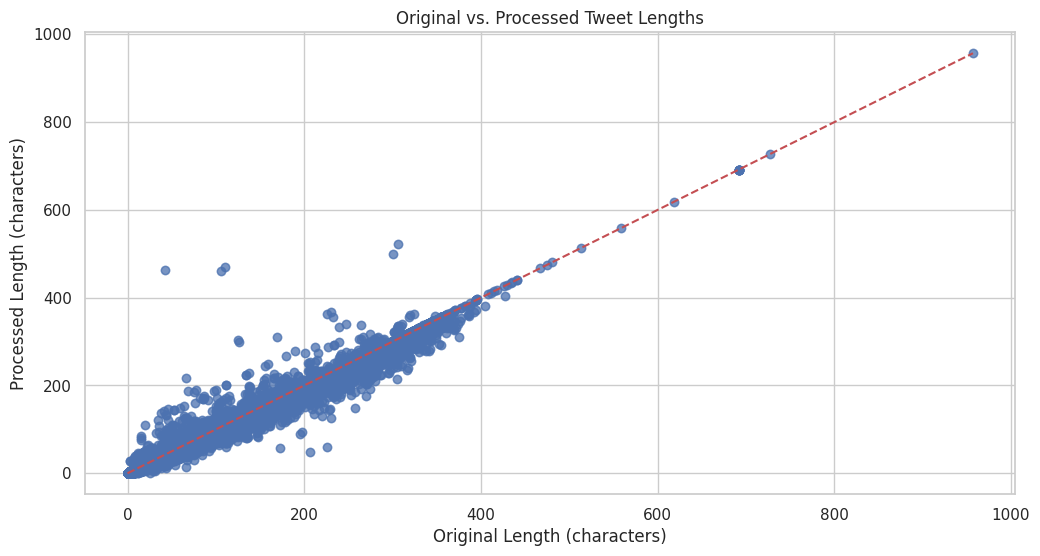

Average reduction in tweet length: 1.83 characters (1.67%)


In [ ]:
# Compare original and processed tweet lengths
df['processed_length'] = df['cleaned_content'].apply(len)

plt.figure(figsize=(12, 6))
plt.scatter(df['tweet_length'], df['processed_length'], alpha=0.5)
plt.plot([0, df['tweet_length'].max()], [0, df['tweet_length'].max()], 'r--')  # Diagonal line
plt.title('Original vs. Processed Tweet Lengths')
plt.xlabel('Original Length (characters)')
plt.ylabel('Processed Length (characters)')
plt.show()

# Average reduction in length
reduction = (df['tweet_length'] - df['processed_length']).mean()
percent_reduction = (reduction / df['tweet_length'].mean()) * 100
print(f"Average reduction in tweet length: {reduction:.2f} characters ({percent_reduction:.2f}%)")

## 7. Train/Validation/Test Splitting

Before saving the processed dataset, we'll split it into train, validation, and test sets. Since the dataset is imbalanced with negative samples accounted for over 30% of the datasets. Some data augmentation methods are adopted to slightly amend the training set.

Original dataset shape: (147378, 7)
Train set: 103164 samples (70.00%)
Validation set: 22107 samples (15.00%)
Test set: 22107 samples (15.00%)

Class distribution in training set:
sentiment
Negative      31194
Positive      28800
Neutral       25225
Irrelevant    17945
Name: count, dtype: int64

Class distribution in validation set:
sentiment
Negative      6684
Positive      6172
Neutral       5405
Irrelevant    3846
Name: count, dtype: int64

Class distribution in test set:
sentiment
Negative      6684
Positive      6172
Neutral       5406
Irrelevant    3845
Name: count, dtype: int64


Text(0, 0.5, 'Count')

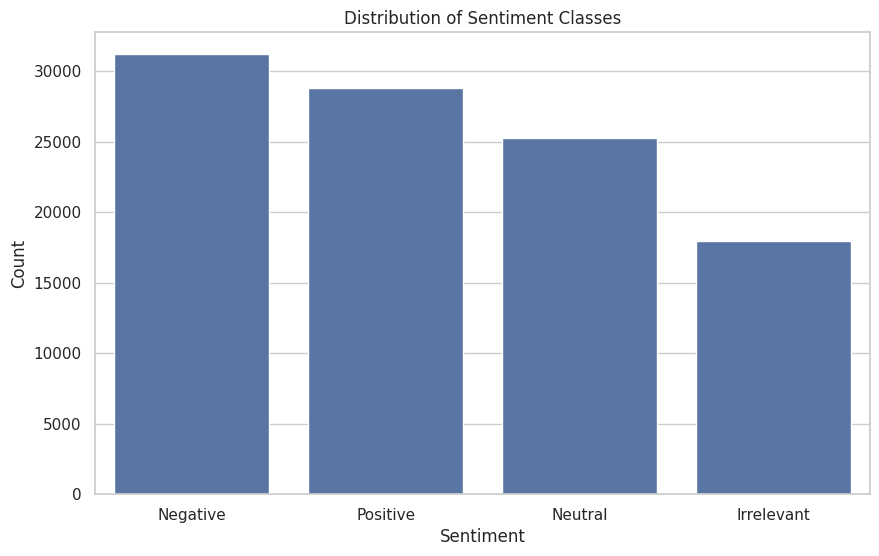

In [ ]:
# Import necessary libraries for splitting
from sklearn.model_selection import train_test_split
import numpy as np

# Split data into train, validation, and test sets (70%, 15%, 15%)
def split_data(df, test_size=0.15, val_size=0.15, random_state=42, stratify_col='sentiment'):
    print(f"Original dataset shape: {df.shape}")

    # First split: training + validation vs test
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=df[stratify_col] if stratify_col else None
    )

    # Second split: training vs validation
    # Adjust validation size to be a percentage of the training + validation set
    val_ratio = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_ratio,
        random_state=random_state,
        stratify=train_val_df[stratify_col] if stratify_col else None
    )

    print(f"Train set: {train_df.shape[0]} samples ({train_df.shape[0]/df.shape[0]:.2%})")
    print(f"Validation set: {val_df.shape[0]} samples ({val_df.shape[0]/df.shape[0]:.2%})")
    print(f"Test set: {test_df.shape[0]} samples ({test_df.shape[0]/df.shape[0]:.2%})")

    return train_df, val_df, test_df

# Split the dataset
train_df, val_df, test_df = split_data(df, stratify_col='sentiment')

# Check class distribution in each split
print("\nClass distribution in training set:")
print(train_df['sentiment'].value_counts())
print("\nClass distribution in validation set:")
print(val_df['sentiment'].value_counts())
print("\nClass distribution in test set:")
print(test_df['sentiment'].value_counts())

# Distribution of sentiment classes
plt.figure(figsize=(10, 6))
sentiment_counts = train_df['sentiment'].value_counts()
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [ ]:
# Data augmentation for rebalancing
from nltk.corpus import wordnet
import random

def synonym_replacement(text, n=2):
    """Replace n random words in the text with their synonyms."""
    words = text.split()
    new_words = words.copy()
    random_indices = random.sample(range(len(words)), min(n, len(words)))

    for idx in random_indices:
        synonyms = wordnet.synsets(words[idx])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            if synonym != words[idx]:
                new_words[idx] = synonym

    return ' '.join(new_words)

def augment_data(subset, sentiment, target_count):
    """Augment data to reach the target count for each class."""
    augmented_data = []

    while len(subset) + len(augmented_data) < target_count:
        for _, row in subset.iterrows():
            augmented_text = synonym_replacement(row['cleaned_content'])
            if augmented_text != row['cleaned_content']:
                augmented_data.append({
                    'content': row['cleaned_content'],
                    'cleaned_content': augmented_text,
                    'entity': row['entity'],
                    'sentiment': row['sentiment']
                })
            if len(subset) + len(augmented_data) >= target_count:
                break

    # Print some augmented samples for verification
    print("\nSample augmented tweets:")
    sampled_augmented = random.sample(augmented_data, min(3, len(augmented_data)))
    for i, sample in enumerate(sampled_augmented):
        print(f"Original: {sample['content']}")
        print(f"Augmented: {sample['cleaned_content']}")
        print("-")

    augmented_df = pd.DataFrame(augmented_data)
    return pd.concat([subset, augmented_df], ignore_index=True)

# Target sample count per class
target_count = 27000

for sentiment in train_df['sentiment'].unique():
    subset = train_df[train_df['sentiment'] == sentiment]
    others_df = train_df[train_df['sentiment'] != sentiment]
    current_count = len(subset)

    if current_count < target_count:
        # Augment training data
        print(f"Augmenting {sentiment} class: {current_count} -> {target_count}")
        augmented_df = augment_data(subset, sentiment, target_count)
        train_df = pd.concat([others_df, augmented_df], ignore_index=True)
    else:
        # Downsampling
        print(f"Downsampling {sentiment} class: {current_count} -> {target_count}")
        downsampled_df = subset.sample(target_count, random_state=42)
        train_df = pd.concat([others_df, downsampled_df], ignore_index=True)

# Combine original and augmented data
print(f"Training set size after rebalancing: {len(train_df)}")

# Verify class distribution
print("\nClass distribution after rebalancing:")
print(train_df['sentiment'].value_counts())

Downsampling Negative class: 31194 -> 27000
Downsampling Positive class: 28800 -> 27000
Augmenting Neutral class: 25225 -> 27000

Sample augmented tweets:
Original: i just deserved [the halls of disgust]!
Augmented: i just deserve [the halls of disgust]!
-
Original: and ranked apex legends with randi's. gold iv. doyouhavefaith.com twitch.tv/thefaithisdope
Augmented: and rank apex legends with randi's. gold iv. doyouhavefaith.com twitch.tv/thefaithisdope
-
Original: year's next for
Augmented: year's following for
-
Augmenting Irrelevant class: 17945 -> 27000

Sample augmented tweets:
Original: oh boy i bet the responses to this in with the comments will be very level - headed words and not at all all a verbal barrage really of outrage and anger.
Augmented: oh boy i bet the responses to this in with the comments will be very level - head words and not at all all a verbal barrage really of indignation and anger.
-
Original: today to. you played so badly in fifa today. see lau pa sat with 

## Save Cleaned Dataset for Feature Engineering

In [ ]:
# Tokenize cleaned content
train_df['tokens'] = train_df['cleaned_content'].apply(lambda x: [word for word in word_tokenize(x) if word != '[USER]'] if isinstance(x, str) else [])
val_df['tokens'] = val_df['cleaned_content'].apply(lambda x: [word for word in word_tokenize(x) if word != '[USER]'] if isinstance(x, str) else [])
test_df['tokens'] = test_df['cleaned_content'].apply(lambda x: [word for word in word_tokenize(x) if word != '[USER]'] if isinstance(x, str) else [])

# Select columns to save
train_df = train_df[['content', 'cleaned_content', 'tokens', 'entity', 'sentiment']]
val_df = val_df[['content', 'cleaned_content', 'tokens', 'entity', 'sentiment']]
test_df = test_df[['content', 'cleaned_content', 'tokens', 'entity', 'sentiment']]


# Save to CSV for the next stage
train_csv_path = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/data/twitter_training_clean.csv'
train_df.to_csv(train_csv_path, index=False)
val_csv_path = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/data/twitter_validation_clean.csv'
val_df.to_csv(val_csv_path, index=False)
test_csv_path = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/data/twitter_testing_clean.csv'
test_df.to_csv(test_csv_path, index=False)

print(f"Training dataset saved to {train_csv_path}")
print(f"Validation dataset saved to {val_csv_path}")
print(f"Testing dataset saved to {test_csv_path}")